In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import sys
#replace the '/home/karl/Astroplan/astroplan' with wherever the directory is
sys.path.insert(0,'/home/karl/Astroplan/astroplan')

In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

import pytz

import astroplan
from astroplan import Observer, FixedTarget, ObservingBlock, SequentialScheduler, Transitioner

from astroplan import plots
color_cycle = plots.mplstyles.astropy_mpl_style['axes.color_cycle']

In [4]:
# define the observer (telscope) and timezone
pal = Observer.at_site('Palomar', timezone=pytz.timezone('US/Pacific'))
pal

<Observer: name='Palomar',
    location (lon, lat, el)=(-116.86300000000001 deg, 33.356 deg, 1706.0000000002024 m),
    timezone=<DstTzInfo 'US/Pacific' LMT-1 day, 16:07:00 STD>>

In [5]:
# find midnight as our start time
midnight = pal.midnight(Time('2015-11-03 5:00'))
midnight

<Time object: scale='utc' format='jd' value=2457329.8132572477>

In [6]:
# define the targets
targets = [FixedTarget.from_name('Vega'),
           FixedTarget.from_name('Deneb'),
           FixedTarget.from_name('Altair'),
           FixedTarget.from_name('Albireo')]
targets

[<FixedTarget "Vega" at SkyCoord (ICRS): (ra, dec) in deg (279.23473479, 38.78368896)>,
 <FixedTarget "Deneb" at SkyCoord (ICRS): (ra, dec) in deg (310.35797975, 45.28033881)>,
 <FixedTarget "Altair" at SkyCoord (ICRS): (ra, dec) in deg (297.6958273, 8.8683212)>,
 <FixedTarget "Albireo" at SkyCoord (ICRS): (ra, dec) in deg (292.68033548, 27.95968007)>]

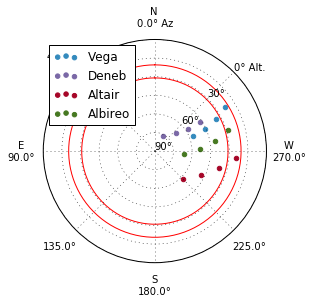

In [7]:
# plot the altitude and azimuth of each object over the next few hours
# this is for visualization (not required for the scheduler)
t1 = pal.twilight_evening_astronomical(midnight)
ts = t1 + [0, 1, 2, 3]*u.hour
for target, c in zip(targets, color_cycle):
    plots.plot_sky(target, pal, ts, style_kwargs=dict(color=c))
# plot 100-sided polygons at altitudes at 30 and ~15 degrees
plt.plot(np.linspace(0,2*np.pi,100), [np.degrees(np.arccos(1/2))]*100, color='r')
plt.plot(np.linspace(0,2*np.pi,100), [np.degrees(np.arccos(1/3))]*100, color='r')
plt.legend(loc='upper left')

In [8]:
# define the list of ObservingBlocks that will be input into the scheduler
etime = 5*u.min
n = 10
rot = 55*u.second

blocks = [ObservingBlock.from_exposures(t, 1, etime, n, rot) for t in targets]
blocks

[<astroplan.scheduling.ObservingBlock (Vega, unscheduled) at 0x7fc0f34aa128>,
 <astroplan.scheduling.ObservingBlock (Deneb, unscheduled) at 0x7fc0f34a2fd0>,
 <astroplan.scheduling.ObservingBlock (Altair, unscheduled) at 0x7fc0f40e4278>,
 <astroplan.scheduling.ObservingBlock (Albireo, unscheduled) at 0x7fc11c493198>]

In [9]:
# create the constraints that the an ObservingBlock must fulfill for it to be scheduled
# at a certain time. non-boolean constraint will consider if it is closer to ideal
# rather than just if it is True or False.
constraints = [astroplan.constraints.AirmassConstraint(3, boolean_constraint=False),
               astroplan.constraints.AtNightConstraint(18*u.deg)
               #,astroplan.constraints.MoonSeparationConstraint(5*u.deg)
               ]
# describe how quickly the telscope transitions
trans = Transitioner(slew_rate=1*u.deg/u.second)

In [10]:
# initialize the scheduler with the start and end times of the observing run,
#     the observer, constraints and transitioner
start_time = pal.twilight_evening_astronomical(midnight)
end_time = pal.twilight_morning_astronomical(midnight)
scheduler = SequentialScheduler(start_time, end_time,
                                constraints=constraints, observer=pal,
                                transitioner=trans)
# run the scheduler on the list of blocks
schedule = scheduler(blocks)
for block in schedule.scheduled_blocks:
    local_start = pal.astropy_time_to_datetime(block.start_time)
    if hasattr(block, 'target'):
        print(block.target.name, 'starting @', local_start, 'lasting', block.duration)
    else:
        print('trans starting @', local_start, 'lasting', block.duration, ':', block.components)

Deneb starting @ 2015-11-02 18:18:54.506594-08:00 lasting 59.16666666666667 min
trans starting @ 2015-11-02 19:18:04.506594-08:00 lasting 22.28673041329236 s : None
Albireo starting @ 2015-11-02 19:18:26.793324-08:00 lasting 59.16666666666667 min
trans starting @ 2015-11-02 20:17:36.793324-08:00 lasting 19.66985495613827 s : None
Altair starting @ 2015-11-02 20:17:56.463179-08:00 lasting 59.16666666666667 min


In [11]:
# to see how well the blocks scored when they were scheduled
[b.constraints_value if hasattr(b, 'constraints_value') else None for b in schedule.observing_blocks]

[0.92233135551552969, 0.53883122888238144, 0.096820190263972608]

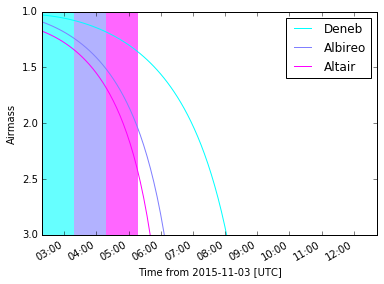

In [12]:
#plotting the observing blocks that were scheduled time vs airmass
plots.plot_schedule_airmass(schedule)
plt.legend(loc=0)

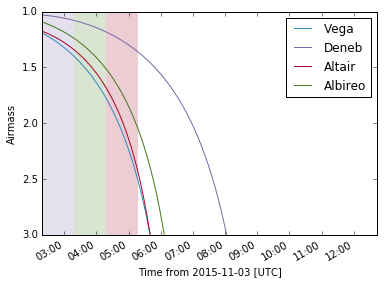

In [13]:
# does essentially the same thing, but plots the airmass of unscheduled targets as well
ts = start_time + np.linspace(0, (end_time-start_time).value, 100)*u.day
targ_to_color = {}
for target, c in zip(targets, color_cycle):
    plots.plot_airmass(target, pal, ts, style_kwargs=dict(color=c))
    targ_to_color[target.name] = c
plt.legend(loc=0)

for block in schedule.scheduled_blocks:
    if hasattr(block, 'target'):
        plt.axvspan(block.start_time.plot_date, block.end_time.plot_date, 
                    fc=targ_to_color[block.target.name], lw=0, alpha=.2)
    else:
        plt.axvspan(block.start_time.plot_date, block.end_time.plot_date, 
                    color='k', lw=0, alpha=.2)
ax=plt.gca()